In [ ]:
import numpy as np
import os

# 초기난수 설정
np.random.seed(42)

# matplotlib 설정
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글 출력
matplotlib.rc('font', family='Verdana')
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장 할 폴더
PROJECT_ROOT_DIR = '.'
CHAPTER_ID = 'housing'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images', CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    if tight_layout:
        plt.tight_layout()
        plt.savefig(path, format=fig_extension, dpi=resolution)
    

In [ ]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

In [ ]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


<AxesSubplot:>

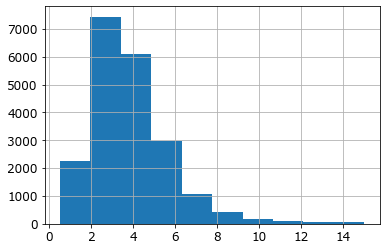

In [ ]:
housing['median_income'].hist()

In [ ]:
housing['income_cat'] = pd.cut(housing['median_income'], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])
housing['income_cat'].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

<AxesSubplot:>

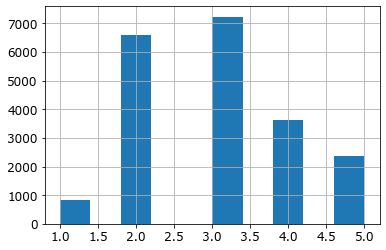

In [ ]:
housing['income_cat'].hist()

In [ ]:
# test set 과 train set 의 분리

from sklearn.model_selection import StratifiedShuffleSplit
from icecream import ic

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    train = housing.loc[train_index]
    test = housing.loc[test_index]

In [ ]:
# label 과 feature 분리
housing = train.drop(columns=['median_house_value'])
housing_labels = train['median_house_value'].copy()

In [ ]:
# 새로운 column 을 만드는 전처리기

from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

# column index dynamicaly
col_names = 'total_rooms', 'total_bedrooms', 'population', 'households'
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):

  def __init__(self, add_bedrooms_per_room = True):
    self.add_bedrooms_per_room  = add_bedrooms_per_room

  # overriding
  def fit(self, x, y=None):
    return self

  # overriding
  def transform(self, X): # X 로 dataset 을 받는다. 단 numpy 형식임
    rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
    population_per_household = X[:, population_ix] / X[:, households_ix]

    if self.add_bedrooms_per_room:
      bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
      return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room] # 모양을 맞춰서 합쳐줌

    else:
      return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
housing_extra_attribs


array([[-121.89, 37.29, 38.0, ..., 2, 4.625368731563422,
        2.094395280235988],
       [-121.93, 37.05, 14.0, ..., 5, 6.008849557522124,
        2.7079646017699117],
       [-117.2, 32.77, 31.0, ..., 2, 4.225108225108225,
        2.0259740259740258],
       ...,
       [-116.4, 34.09, 9.0, ..., 3, 6.34640522875817, 2.742483660130719],
       [-118.01, 33.82, 31.0, ..., 3, 5.50561797752809,
        3.808988764044944],
       [-122.45, 37.77, 52.0, ..., 3, 4.843505477308295,
        1.9859154929577465]], dtype=object)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

housing_num = housing.drop(columns=['ocean_proximity'], axis=1) # 수치형 데이터만 추출함

# 수치형 데이터의 파이프라인을 제작함
num_pipeline = Pipeline([
  ('imputer', SimpleImputer(strategy='median')),
  ('attribs_adder', CombinedAttributesAdder()),
  ('std_scaler', StandardScaler())
])

num_pipeline.fit_transform(housing_num)

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_attribs = list(housing)
num_attribs.remove('ocean_proximity')
cat_attribs = ['ocean_proximity']

# 이건 파이프라인은 아니고 column 마다 transformer 먹이는 것
preproc_pipeline = ColumnTransformer([
  ('num', num_pipeline, num_attribs),
  ('cat', OneHotEncoder(), cat_attribs)
])
housing_prepared = preproc_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [13]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

svm_reg = SVR(kernel='linear', C=1, gamma=1.0)
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

106874.50415237379

In [14]:
housing_prepared.shape[0]

16512

# 과제 1-1 GridSearch

In [15]:
# Grid search 경우의수는 3 * 2 * 5 = 30
from sklearn.model_selection import GridSearchCV
param_grid = [
  {'kernel': ['linear', 'poly', 'rbf'],
  'gamma': ['scale', 'auto'],
  'C': [0.5, 1.0, 2.0]
  }
]
svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=3, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=3, estimator=SVR(),
             param_grid=[{'C': [0.5, 1.0, 2.0], 'gamma': ['scale', 'auto'],
                          'kernel': ['linear', 'poly', 'rbf']}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [16]:
 # 최고의 parameter 와 estimator 를 찾을 수 있다.
print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'C': 2.0, 'gamma': 'scale', 'kernel': 'linear'}
SVR(C=2.0, kernel='linear')


In [17]:
# 각 조건의 loss
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
  print(np.sqrt(-mean_score), params)

114420.23745848304 {'C': 0.5, 'gamma': 'scale', 'kernel': 'linear'}
118922.03246251818 {'C': 0.5, 'gamma': 'scale', 'kernel': 'poly'}
118771.15144807284 {'C': 0.5, 'gamma': 'scale', 'kernel': 'rbf'}
114420.23745848304 {'C': 0.5, 'gamma': 'auto', 'kernel': 'linear'}
119064.67639212901 {'C': 0.5, 'gamma': 'auto', 'kernel': 'poly'}
118768.85207908791 {'C': 0.5, 'gamma': 'auto', 'kernel': 'rbf'}
110436.03950820222 {'C': 1.0, 'gamma': 'scale', 'kernel': 'linear'}
118646.71070966855 {'C': 1.0, 'gamma': 'scale', 'kernel': 'poly'}
118609.36960049583 {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
110436.03950820222 {'C': 1.0, 'gamma': 'auto', 'kernel': 'linear'}
118960.96654350724 {'C': 1.0, 'gamma': 'auto', 'kernel': 'poly'}
118605.2523463583 {'C': 1.0, 'gamma': 'auto', 'kernel': 'rbf'}
103774.1609320601 {'C': 2.0, 'gamma': 'scale', 'kernel': 'linear'}
118156.12413843392 {'C': 2.0, 'gamma': 'scale', 'kernel': 'poly'}
118282.31986429312 {'C': 2.0, 'gamma': 'scale', 'kernel': 'rbf'}
103774.160932

# 과제 1-2 RandomizedSearch

In [19]:
# grid search 에서 나온 조건을 더 검증하기위해 C 를 random search 해보자
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal
param_distribs = {
  'C': reciprocal(20, 20000)
}
svm_reg = SVR(kernel='linear', gamma='scale')
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs, \
  n_iter=10, cv=3, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)
rnd_search.best_params_

{'C': 1250.2747149043494}

In [26]:
best_params = rnd_search.best_params_
best_params.update(grid_search.best_params_)

final_pipeline = Pipeline([
    ('preparation', preproc_pipeline),
    ('svm_reg', SVR(**best_params))
])

# 과제 2: Pipeline

In [27]:
final_pipeline.fit(housing, housing_labels)

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                    

In [28]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", final_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [164123.92264037 224583.34445439 164106.69306833 143649.02441946]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0]


In [29]:
best_params = rnd_search.best_params_
best_params.update(grid_search.best_params_)

In [31]:
best_params

{'C': 2.0, 'gamma': 'scale', 'kernel': 'linear'}